# Breaking down De-Trending

In [1]:
# imports
import os, glob
import numpy as np
from scipy import signal
import datetime

import xarray

import matplotlib
from matplotlib import pyplot as plt

from mhw import climate
from mhw import utils as mhw_utils

In [2]:
def set_fontsize(ax,fsz):
    """
    Set the fontsize throughout an Axis
    
    Args:
        ax (Matplotlib Axis): 
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)

# Load up SST data

In [3]:
# Grab the list of SST V2 files
noaa_path = os.getenv("NOAA_OI")
sst_root = 'sst.day*nc'
#
all_sst_files = glob.glob(os.path.join(noaa_path, sst_root))
all_sst_files.sort()

In [4]:
climatologyPeriod = (1983,2019)
for ii, ifile in enumerate(all_sst_files):
    if str(climatologyPeriod[0]) in ifile:
        istart = ii
    if str(climatologyPeriod[1]) in ifile:
        iend = ii
all_sst_files = all_sst_files[istart:iend+1]

print("Loading up the files. Be patient...")
lat_coord, lon_coord, t, all_sst = mhw_utils.load_noaa_sst(
    all_sst_files)

Loading up the files. Be patient...
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1983.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1984.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1985.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1986.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1987.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1988.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1989.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1990.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1991.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1992.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1993.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1994.nc
/data/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/sst.day.mean.1995.nc
/data/Projects/

In [38]:
time_dict = climate.build_time_dict(t)
dates = [datetime.datetime.fromordinal(it) for it in t]

# Load 2019 climatology

In [7]:
climate_file = os.path.join(os.getenv('NOAA_OI'), 
                            'NOAA_OI_climate_1983-2019.nc')
ds = xarray.open_dataset(climate_file)
sT_data = ds.seasonalT.values

In [31]:
ds

<xarray.Dataset>
Dimensions:    (doy: 366, lat: 720, lon: 1440)
Coordinates:
  * doy        (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * lat        (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
Data variables:
    seasonalT  (doy, lat, lon) float32 0.0 0.0 0.0 ... -1.7399963 -1.7400757
    threshT    (doy, lat, lon) float32 ...

# Isolate March 1 in the Pacific

## Load up all of the days

In [8]:
i_Npacific = np.argmin(np.abs(ds.lat.values-36.125))
j_Npacific = np.argmin(np.abs(ds.lon.values-220.125))
#
i_Npacific, j_Npacific

(504, 880)

In [9]:
allT_Npacific = mhw_utils.grab_T(all_sst, i_Npacific, j_Npacific)

## DOY

In [32]:
doy_march1 = 61 # March 1

## Calculate climatology

### $C(DOY, i, j)$

In [11]:
# Window for smoothing
windowHalfWidth=5
wHW_array = np.outer(np.ones(1000, dtype='int'), np.arange(-windowHalfWidth, windowHalfWidth + 1))

In [16]:
# Params
doyClim = time_dict['doy']
TClim = len(doyClim)

clim_start = 0
clim_end = len(doyClim)
pctile = 90.
nwHW = wHW_array.shape[1]

In [33]:
_d = doy_march1
tempClim = allT_Npacific
ones = np.array([1]*nwHW) #np.ones(nwHW).astype(int)
#
tt0 = np.where(doyClim[clim_start:clim_end+1] == _d)[0]
# Main calculation
tt = (wHW_array[0:len(tt0),:] + np.outer(tt0, ones)).flatten()
gd = (tt >= 0) & (tt<TClim)
tt = tt[gd] # Reject indices "after" the last element
thresh_climYear = np.nanpercentile(tempClim[tt], pctile)
seas_climYear = np.nanmean(tempClim[tt])

In [34]:
thresh_climYear, seas_climYear

(15.679999542236331, 14.514349)

### Plot:  SST vs. time

#### Note that because we average over +/- 5days, there are 10 points per March 1 for ~300 data points total

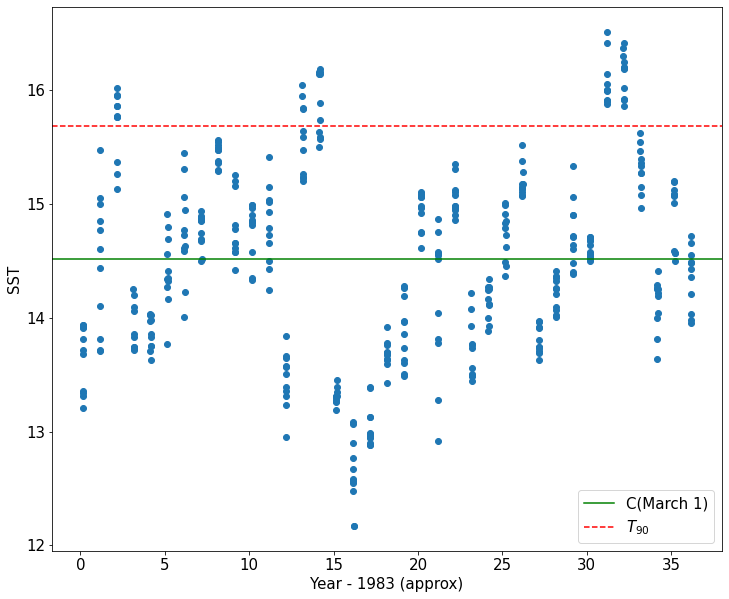

In [30]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
ax.scatter(tt/365., tempClim[tt])
# C
ax.axhline(seas_climYear, color='g', ls='-', label=r'C(March 1)')
# T90
ax.axhline(thresh_climYear, color='r', ls='--', label=r'$T_{90}$')
#
ax.set_ylabel('SST')
ax.set_xlabel('Year - 1983 (approx)')
#
ax.legend(loc='lower right', fontsize=15.)
#
set_fontsize(ax, 15.)
#
plt.show()

## Now consider the SST anomaly from the climatology for all days at this location

### ${\rm SST_a(t,i,j)} = {\rm SST(DOY,i,j)} - C(DOY,i,j)$

In [36]:
C_ij = [ds.seasonalT[doy-1, i_Npacific, j_Npacific] for doy in doyClim]

In [37]:
SSTa_tij = allT_Npacific - C_ij

### Plot:  ${\rm SSTa(t,i,j)}$ vs. $t$

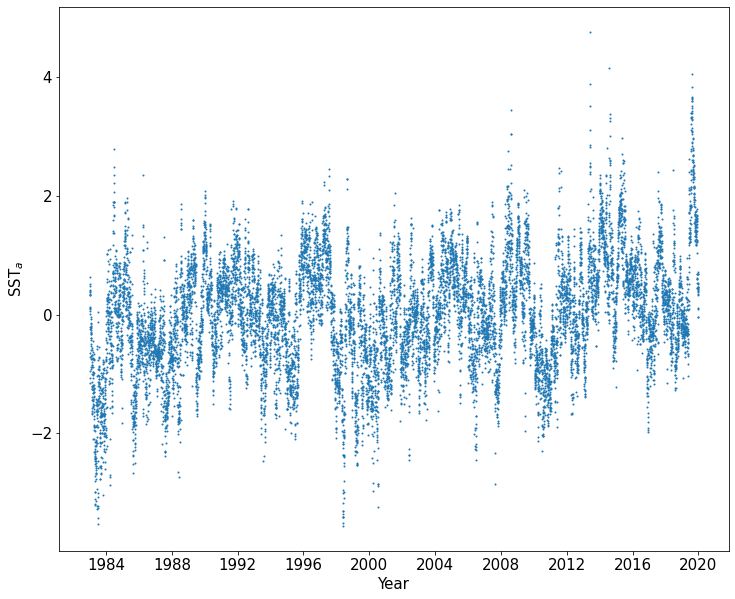

In [40]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
mdates = matplotlib.dates.date2num(dates)

ax.plot_date(mdates, SSTa_tij, ms=1)

ax.set_ylabel(r'SST$_a$')
ax.set_xlabel('Year')
#
#ax.legend(loc='lower right', fontsize=15.)
#
set_fontsize(ax, 15.)
#
plt.show()

## Define $DT(i,j)$ as the linear de-trend fitted to a given location $i,j$ on the ocean.

### We will simply fit a linear relationship between ${\rm SST_a}$ and ordinal time (shifted to 0, although this is not necessary).

In [42]:
t_0 = t - t[0]

In [43]:
fit = np.polyfit(t_0, SSTa_tij, 1)

In [46]:
# Slope of DT is the first number, in units of Kelvin/day
fit

array([ 6.92616573e-05, -4.67854214e-01])

In [44]:
# function for evaluation
f = np.poly1d(fit)

### Plot:  ${\rm SST_a}(t,i,j)$ vs. $t$ and $DT$

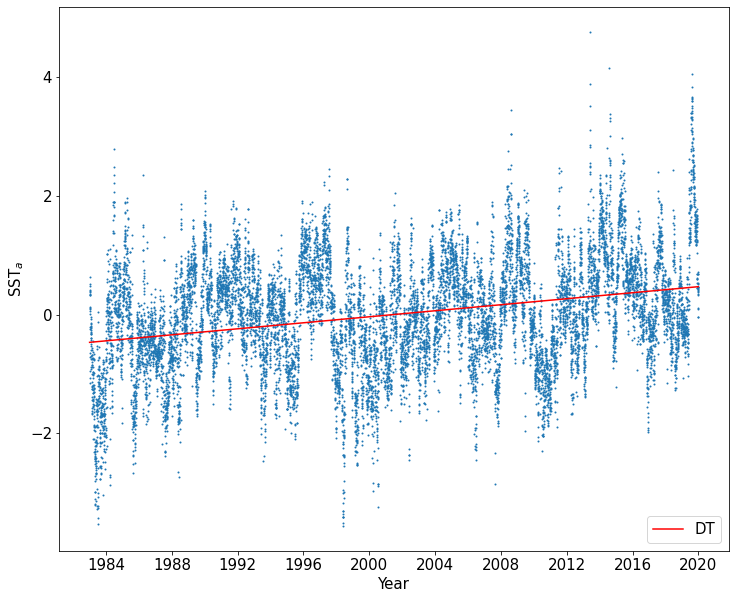

In [48]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
mdates = matplotlib.dates.date2num(dates)

ax.plot_date(mdates, SSTa_tij, ms=1)

# DT
ax.plot_date(mdates, f(t_0), 'r-', label='DT')

ax.set_ylabel(r'SST$_a$')
ax.set_xlabel('Year')
#
ax.legend(loc='lower right', fontsize=15.)
#
set_fontsize(ax, 15.)
#
plt.show()

## Ok, but now we need to recalculate our Climatology and T90!

### Define: ${\rm SST'}(t,i,j) = {\rm SST}(t,i,j) - DT(t,i,j)$

### And we will have a new climatology $C'$ and $T_{90}'$

In [49]:
SST_p = allT_Npacific - f(t_0)

In [50]:
# New climatology
_d = doy_march1
tempClim = SST_p
ones = np.array([1]*nwHW) #np.ones(nwHW).astype(int)
#
tt0 = np.where(doyClim[clim_start:clim_end+1] == _d)[0]
# Main calculation
tt = (wHW_array[0:len(tt0),:] + np.outer(tt0, ones)).flatten()
gd = (tt >= 0) & (tt<TClim)
tt = tt[gd] # Reject indices "after" the last element
thresh_climYear_p = np.nanpercentile(tempClim[tt], pctile)
seas_climYear_p = np.nanmean(tempClim[tt])

In [52]:
thresh_climYear_p, thresh_climYear

(15.73031958102949, 15.679999542236331)

In [53]:
seas_climYear_p, seas_climYear

(14.522730327225947, 14.514349)

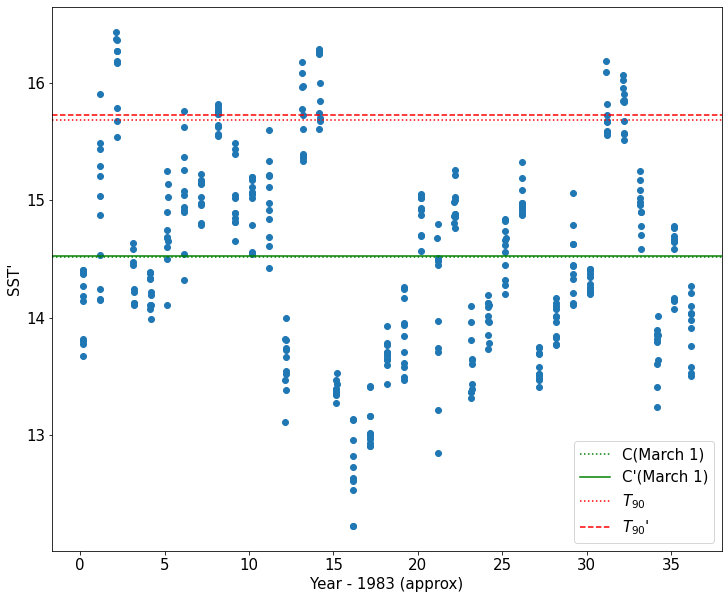

In [56]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
# SST'
ax.scatter(tt/365., SST_p[tt])
# C, C'
ax.axhline(seas_climYear, color='g', ls=':', label=r'C(March 1)')
ax.axhline(seas_climYear_p, color='g', ls='-', label=r"C'(March 1)")
# T90
ax.axhline(thresh_climYear, color='r', ls=':', label=r'$T_{90}$')
ax.axhline(thresh_climYear_p, color='r', ls='--', label=r"$T_{90}$'")
#
ax.set_ylabel("SST'")
ax.set_xlabel('Year - 1983 (approx)')
#
ax.legend(loc='lower right', fontsize=15.)
#
set_fontsize(ax, 15.)
#
plt.show()